# (E04)4th_project-Movie_Review_Sentiment_ Analysis
***********************************************************************************************


## 1. 데이터 준비와 확인

      20만개로 이루어진 네이버 영화 평론 댓글 모음을 준비하고 전처리를 진행한다.

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

훈련용 리뷰 개수 : 150000
테스트용 리뷰 개수 : 50000


      불러온 데이터가 훈련용 150000개, 테스트용 50000개로 총 20만개인것을 확인할 수 있다.

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
num_words = 10000

      불용어를 제거하는 코드입니다.

In [3]:
train_data.drop_duplicates(subset=['document'], inplace=True)
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 146183


      불용어를 제거 한 후 훈련용 리뷰에서 중복된 리뷰를 찾아 제거합니다.
      남은 훈련용 리뷰 개수는 146183개입니다

In [4]:
print(train_data.isnull().values.any())
train_data = train_data.dropna(how = 'any') 

print(train_data.isnull().values.any())
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

True
False
훈련용 리뷰 개수 : 146182


      남은 훈련용 리뷰에서 값이 없는(NULL) 리뷰가 있는지 찾습니다
      존재한다면 두번째 줄 코드를 실행하여 제거하고 다시 있는지 확인합니다.
      1개가 제거되어 146182개가 남아있습니다.

In [5]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

train_data = train_data.dropna(how = 'any')
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

id            0
document    391
label         0
dtype: int64
훈련용 리뷰 개수 : 145791


      마지막으로 한글과 공백을 제외한 나머지를 제거하는 코드를 실행해줍니다.
      숫자, 영어, 특수기호로만 이루어진 리뷰가 총 391개로 NULL값을 가지게 된 것을 알 수 있습니다.
      마찬가지로 공백이 된 이 데이터를 제거해줍니다.

In [6]:
test_data.drop_duplicates(subset=['document'], inplace=True)
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력\

테스트용 리뷰 개수 : 49158


In [7]:
print(test_data.isnull().values.any())
test_data = test_data.dropna(how = 'any') 

print(test_data.isnull().values.any())
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

True
False
테스트용 리뷰 개수 : 49157


In [8]:
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['document'].replace('', np.nan, inplace=True)
print(test_data.isnull().sum())

test_data = test_data.dropna(how = 'any')
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

id            0
document    162
label         0
dtype: int64
테스트용 리뷰 개수 : 48995


      위의 훈련용 데이터에 해준 과정을 테스트 데이터에도 시행해줍니다,
      남은 것이 총 48995개인 것을 확인 할 수 있습니다.

In [9]:
X_train = []
for sentence in train_data['document']:
    temp_X = tokenizer.morphs(sentence) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

X_test = []
for sentence in test_data['document']:
    temp_X = tokenizer.morphs(sentence) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

      남은 리뷰 데이터들을 토큰화 해줍니다

In [10]:
words = np.concatenate(X_train).tolist()
vocab_size = 10000
counter = Counter(words)
counter = counter.most_common(vocab_size-4)
vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
word_to_index = {word:index for index, word in enumerate(vocab)}

def wordlist_to_indexlist(wordlist):
    return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

X_train = list(map(wordlist_to_indexlist, X_train))
X_test = list(map(wordlist_to_indexlist, X_test))

y_train = np.array(list(train_data['label']))
y_test = np.array(list(test_data['label']))


print('훈련용 리뷰 개수 :',len(X_train)) # 훈련용 리뷰 개수 출력
print('테스트용 리뷰 개수 :',len(X_test)) # 테스트용 리뷰 개수 출력
print(y_train.shape)

훈련용 리뷰 개수 : 145791
테스트용 리뷰 개수 : 48995
(145791,)


      텍스트 스트링을 사전 인덱스 스트링으로 변환해줍니다.

In [11]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [12]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [13]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  13.757179674103888
문장길이 최대 :  83
문장길이 표준편차 :  11.462771769216866
pad_sequences maxlen :  36
전체 문장의 0.9338145451931864%가 maxlen 설정값 이내에 포함됩니다. 


      문장길이의 평균과 최대, 표준편차를 구하고 약 93%의 길이인 36을 최대 길이로 설정해줍니다.

In [14]:
print(X_train[0])

print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

[27, 67, 895, 33, 214, 15, 28, 699]
더 빙 진짜 짜증 나 네요 목소리
라벨:  0


      리뷰 데이터 변환이 잘 진행됬는지 확인해봅니다.

In [15]:
x_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(x_train.shape)
print(y_train.shape)

(145791, 36)
(145791,)


       padding 방식을 문장 뒷쪽('post')과 앞쪽('pre') 중 어느쪽으로 하느냐에 따라 RNN을 이용한 딥러닝 적용 시 성능 차이가 발생한다. 성능이 더 좋은 'pre'를 이용해서 학습을 진행한다.

In [16]:
# validation set 45791건 분리
x_val = x_train[:45791]   
y_val = y_train[:45791]

# validation set을 제외한 나머지 100000건
partial_x_train = x_train[45791:]  
partial_y_train = y_train[45791:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(100000, 36)
(100000,)


      테스트 리뷰 45791개를 검증셋으로 넘기고 나머지는 학습용으로 씁니다.

## 2. 각종 모델 학습 결과와 평가

### 1)  RNN 모델

In [17]:
#RNN 모델
#vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model_RNN = keras.Sequential()

model_RNN.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_RNN.add(keras.layers.LSTM(word_vector_dim))   
model_RNN.add(keras.layers.Dense(8, activation='relu'))
model_RNN.add(keras.layers.Dense(1, activation='sigmoid'))  

model_RNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 8)                 808       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,081,217
Trainable params: 1,081,217
Non-trainable params: 0
_________________________________________________________________


In [18]:
model_RNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_RNN = model_RNN.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(x_val, y_val), verbose=1)

Epoch 1/20
196/196 [==============================] - 3s 14ms/step - loss: 0.4580 - accuracy: 0.7840 - val_loss: 0.3619 - val_accuracy: 0.8398
Epoch 2/20
196/196 [==============================] - 3s 13ms/step - loss: 0.3413 - accuracy: 0.8525 - val_loss: 0.3523 - val_accuracy: 0.8445
Epoch 3/20
196/196 [==============================] - 3s 13ms/step - loss: 0.3126 - accuracy: 0.8661 - val_loss: 0.3569 - val_accuracy: 0.8450
Epoch 4/20
196/196 [==============================] - 3s 13ms/step - loss: 0.2865 - accuracy: 0.8793 - val_loss: 0.3577 - val_accuracy: 0.8436
Epoch 5/20
196/196 [==============================] - 3s 13ms/step - loss: 0.2648 - accuracy: 0.8886 - val_loss: 0.3762 - val_accuracy: 0.8457
Epoch 6/20
196/196 [==============================] - 3s 13ms/step - loss: 0.2399 - accuracy: 0.9002 - val_loss: 0.3976 - val_accuracy: 0.8433
Epoch 7/20
196/196 [==============================] - 3s 13ms/step - loss: 0.2189 - accuracy: 0.9086 - val_loss: 0.4025 - val_accuracy: 0.8414

In [19]:
results = model_RNN.evaluate(x_test,  y_test, verbose=2)
history_dict = history_RNN.history

print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

1532/1532 - 2s - loss: 0.9608 - accuracy: 0.8223
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


      RNN 모델의 경우 20번 학습을 진행한 결과 약 82.23%의 정확도를 보였습니다.

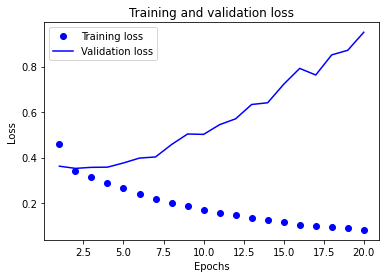

In [20]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

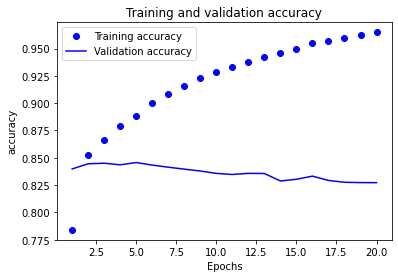

In [21]:
plt.plot(epochs, acc, 'bo', label='Training accuracy')

plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

      분석을 통해 확인해 본 결과 가장 적절한 epoch의 수는 5회로 보입니다. 이떄의 정확도는 약 85%였습니다.

### 2) 1-D CNN 모델

In [22]:
#1-D CNN 모델
#vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model_CNN = keras.Sequential()
model_CNN.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_CNN.add(keras.layers.Conv1D(16, 6, activation='relu'))
model_CNN.add(keras.layers.MaxPooling1D(5))
model_CNN.add(keras.layers.Conv1D(16, 6, activation='relu'))
model_CNN.add(keras.layers.GlobalMaxPooling1D())
model_CNN.add(keras.layers.Dense(8, activation='relu'))
model_CNN.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          9616      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1552      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [23]:
model_CNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_CNN = model_CNN.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(x_val, y_val), verbose=1)

Epoch 1/20
196/196 [==============================] - 10s 51ms/step - loss: 0.4965 - accuracy: 0.7586 - val_loss: 0.3833 - val_accuracy: 0.8261
Epoch 2/20
196/196 [==============================] - 2s 10ms/step - loss: 0.3438 - accuracy: 0.8487 - val_loss: 0.3729 - val_accuracy: 0.8300
Epoch 3/20
196/196 [==============================] - 2s 10ms/step - loss: 0.2862 - accuracy: 0.8792 - val_loss: 0.3810 - val_accuracy: 0.8292
Epoch 4/20
196/196 [==============================] - 2s 10ms/step - loss: 0.2259 - accuracy: 0.9088 - val_loss: 0.4148 - val_accuracy: 0.8263
Epoch 5/20
196/196 [==============================] - 2s 10ms/step - loss: 0.1678 - accuracy: 0.9360 - val_loss: 0.4668 - val_accuracy: 0.8196
Epoch 6/20
196/196 [==============================] - 2s 9ms/step - loss: 0.1248 - accuracy: 0.9535 - val_loss: 0.5338 - val_accuracy: 0.8145
Epoch 7/20
196/196 [==============================] - 2s 9ms/step - loss: 0.0945 - accuracy: 0.9648 - val_loss: 0.6007 - val_accuracy: 0.8112


In [24]:
results = model_CNN.evaluate(x_test,  y_test, verbose=2)
history_dict = history_CNN.history

print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

1532/1532 - 4s - loss: 1.2776 - accuracy: 0.7974
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


      시행 결과 79.74%의 정확도로 가장 낮은 성능을 보였습니다.

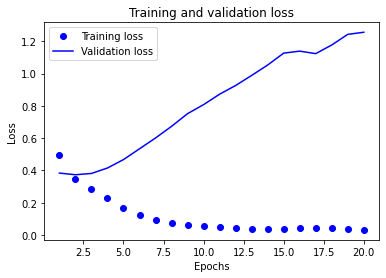

In [25]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

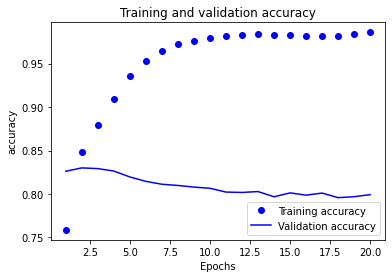

In [26]:
plt.plot(epochs, acc, 'bo', label='Training accuracy')

plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

      시행 횟차를 분석 해 본 결과, 가장 적절한 epoch의 횟수는 3-5회로 보이고 가장 높은 정확도를 보였을 때 약 83%의 정확도를 보였습니다.

### 3) GlobalMaxPooling 모델

In [27]:
#GlobalMaxPooling 모델
#vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 100   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model_GMP = keras.Sequential()
model_GMP.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_GMP.add(keras.layers.GlobalMaxPooling1D())
model_GMP.add(keras.layers.Dense(8, activation='relu'))
model_GMP.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_GMP.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 808       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 1,000,817
Trainable params: 1,000,817
Non-trainable params: 0
_________________________________________________________________


In [28]:
model_GMP.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_GMP = model_GMP.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(x_val, y_val), verbose=1)

Epoch 1/20
196/196 [==============================] - 2s 9ms/step - loss: 0.5439 - accuracy: 0.7650 - val_loss: 0.3872 - val_accuracy: 0.8327
Epoch 2/20
196/196 [==============================] - 2s 8ms/step - loss: 0.3481 - accuracy: 0.8517 - val_loss: 0.3508 - val_accuracy: 0.8443
Epoch 3/20
196/196 [==============================] - 2s 8ms/step - loss: 0.2964 - accuracy: 0.8773 - val_loss: 0.3499 - val_accuracy: 0.8475
Epoch 4/20
196/196 [==============================] - 2s 8ms/step - loss: 0.2595 - accuracy: 0.8947 - val_loss: 0.3581 - val_accuracy: 0.8476
Epoch 5/20
196/196 [==============================] - 2s 8ms/step - loss: 0.2262 - accuracy: 0.9115 - val_loss: 0.3746 - val_accuracy: 0.8460
Epoch 6/20
196/196 [==============================] - 2s 8ms/step - loss: 0.1934 - accuracy: 0.9285 - val_loss: 0.3960 - val_accuracy: 0.8440
Epoch 7/20
196/196 [==============================] - 2s 8ms/step - loss: 0.1624 - accuracy: 0.9435 - val_loss: 0.4221 - val_accuracy: 0.8402
Epoch 

In [29]:
results = model_GMP.evaluate(x_test,  y_test, verbose=2)
history_dict = history_GMP.history

print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

1532/1532 - 1s - loss: 0.8512 - accuracy: 0.8209
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


      약 82%의 정확도로 RNN과 비슷한 성능을 보였습니다.

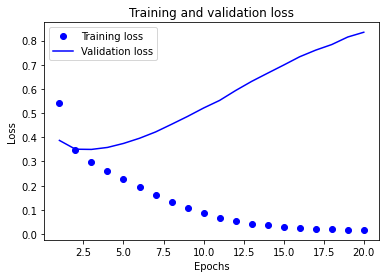

In [30]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

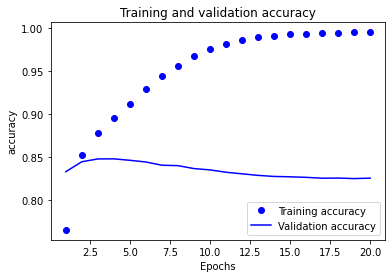

In [31]:
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

      적절한 epoch의 횟수는 3회로 이때 약 85%의 정확도를 보여줬습니다.

## 3. 최고 성능 모델 분석하기

In [32]:
#학습된 Embedding 레이어 분석
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

word_vector_dim = 100  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model_Final = keras.Sequential()

model_Final.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_Final.add(keras.layers.LSTM(word_vector_dim))   
model_Final.add(keras.layers.Dense(8, activation='relu'))
model_Final.add(keras.layers.Dense(1, activation='sigmoid'))  

model_Final.summary()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model_Final.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc']) # val_loss가 4회 증가하면 학습을 종료합니다. val_acc가 가장 높은 모델을 저장합니다. 
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_Final = model_Final.fit(partial_x_train, partial_y_train, epochs=epochs, callbacks=[es, mc], batch_size=512, validation_data=(x_val, y_val), verbose=1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 808       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 1,081,217
Trainable params: 1,081,217
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
196/196 [==============================] - ETA: 0s - loss: 0.4466 - acc: 0.7843
Epoch 00001: val_acc improved from -inf to 0.83951, saving model to best_model.h5
196/196 [==============================] - 3s 15ms/step - loss: 0.446

      검증 데이터 손실(val_loss)이 증가하면, 과적합 징후므로 검증 데이터 손실이 4회 증가하면 학습을 조기 종료(Early Stopping)합니다. 또한, ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장합니다.

In [33]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(x_test, y_test)[1]))

1532/1532 [==============================] - 2s 2ms/step - loss: 0.3637 - acc: 0.8376

 테스트 정확도: 0.8376


      테스트 셋으로 확인해 본 결과 84%의 정확도를 보입니다.

In [34]:
embedding_layer = load_model('best_model.h5')
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 100)


## 4. 학습된 Embedding 레이어 분석

In [35]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = loaded_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [36]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['구토']
vector

word_vectors.similar_by_word("구토")

[('최악', 0.8796914219856262),
 ('감흥', 0.8747795820236206),
 ('엉성', 0.8646913170814514),
 ('왜곡', 0.8637752532958984),
 ('수면제', 0.8634276986122131),
 ('짝퉁', 0.8604995012283325),
 ('낚였', 0.8582966923713684),
 ('맞출', 0.8571181893348694),
 ('하품', 0.856518030166626),
 ('반개', 0.8535510301589966)]

In [37]:
vector = word_vectors['명작']
vector

word_vectors.similar_by_word("명작")

[('수작', 0.9210688471794128),
 ('나무랄', 0.9173898696899414),
 ('쏠쏠', 0.9126120805740356),
 ('수준급', 0.9071028828620911),
 ('만점', 0.9063248634338379),
 ('여운', 0.9009645581245422),
 ('최고', 0.897685170173645),
 ('예뻐요', 0.8976436257362366),
 ('넘사벽', 0.8975391387939453),
 ('뗄', 0.8965908885002136)]

      부정적인 단어와 긍정적인 단어를 하나씩 확인해보자 비슷한 의미의 단어가 근접한 의미로 잘 들어간 것을 볼 수 있다.

## 5. 한국어 Word2Vec 임베딩 활용

In [38]:
#한국어 Word2Vec 임베딩 활용하여 성능개선
from gensim.models import KeyedVectors
from gensim.models.word2vec import Word2Vec
import gensim

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
ko_model = Word2Vec.load(word2vec_path)

vector = ko_model['구토']
vector

ko_model.wv.most_similar('구토')

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


[('두통', 0.8388077020645142),
 ('설사', 0.7648500204086304),
 ('빈혈', 0.7441317439079285),
 ('통증', 0.7423505187034607),
 ('출혈', 0.7408765554428101),
 ('탈수', 0.7358182668685913),
 ('복통', 0.7298648953437805),
 ('경련', 0.7235933542251587),
 ('기침', 0.721824049949646),
 ('고혈압', 0.7157262563705444)]

In [39]:
vector = ko_model['명작']
vector

ko_model.wv.most_similar('명작')

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


[('걸작', 0.7933748364448547),
 ('작품', 0.7375750541687012),
 ('대작', 0.686141848564148),
 ('희극', 0.6746902465820312),
 ('희곡', 0.674653947353363),
 ('거장', 0.6636549830436707),
 ('대표작', 0.6602857112884521),
 ('단편집', 0.6207208633422852),
 ('히트곡', 0.6082459688186646),
 ('가곡', 0.6028263568878174)]

      한국어 Word2Vec 임베딩 활용하여 성능개선을 해보는 과정이다. 각각 위에서 찾았던 단어들의 한국어 Word2Vec 임베딩 유사단어 결과를 찾아보았다.

In [40]:
#vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in ko_model:
        embedding_matrix[i] = ko_model[index_to_word[i]]

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


      만약 한국어 Word2Vec 임베딩에 포함된 단어가 있으면 벡터값을 바꿔준다.

In [41]:
from tensorflow.keras.initializers import Constant

#vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model_RNN_ko = keras.Sequential()

model_RNN_ko.add(keras.layers.Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix), input_length=maxlen, trainable=True))   # trainable을 True로 주면 Fine-tuning
model_RNN_ko.add(keras.layers.LSTM(word_vector_dim))   
model_RNN_ko.add(keras.layers.Dense(4, activation='relu'))
model_RNN_ko.add(keras.layers.Dense(1, activation='sigmoid'))  

model_RNN_ko.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 36, 200)           2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 804       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 5         
Total params: 2,321,609
Trainable params: 2,321,609
Non-trainable params: 0
_________________________________________________________________


      위에서 가장 성능이 좋았던 RNN모델을 활용하여 성능이 얼마나 개선되었는지 확인해본다.

In [45]:
model_RNN_ko.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
mc = ModelCheckpoint('best_ko_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history_RNN_ko = model_RNN_ko.fit(partial_x_train, partial_y_train, epochs=epochs, callbacks=[es, mc], batch_size=512, validation_data=(x_val, y_val), verbose=1)

Epoch 1/20
195/196 [============================>.] - ETA: 0s - loss: 0.1495 - acc: 0.9444
Epoch 00001: val_acc improved from -inf to 0.85298, saving model to best_ko_model.h5
196/196 [==============================] - 7s 35ms/step - loss: 0.1496 - acc: 0.9444 - val_loss: 0.4106 - val_acc: 0.8530
Epoch 2/20
194/196 [============================>.] - ETA: 0s - loss: 0.1199 - acc: 0.9564
Epoch 00002: val_acc did not improve from 0.85298
196/196 [==============================] - 6s 31ms/step - loss: 0.1202 - acc: 0.9563 - val_loss: 0.4731 - val_acc: 0.8481
Epoch 3/20
195/196 [============================>.] - ETA: 0s - loss: 0.1005 - acc: 0.9644
Epoch 00003: val_acc did not improve from 0.85298
196/196 [==============================] - 6s 29ms/step - loss: 0.1005 - acc: 0.9644 - val_loss: 0.5268 - val_acc: 0.8486
Epoch 4/20
195/196 [============================>.] - ETA: 0s - loss: 0.0813 - acc: 0.9718
Epoch 00004: val_acc did not improve from 0.85298
196/196 [==========================

      Epoch가 7회 시행되고 종료되었고 저장된 모델은 epoch가 3회인 정확도 85.8%일 때 저장되었다. 

In [43]:
results = model_RNN_ko.evaluate(x_test,  y_test, verbose=2)

print(results)

1532/1532 - 2s - loss: 0.3835 - acc: 0.8521
[0.3835199475288391, 0.8521073460578918]


In [44]:
loaded_model = load_model('best_ko_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(x_test, y_test)[1]))

1532/1532 [==============================] - 3s 2ms/step - loss: 0.3364 - acc: 0.8520

 테스트 정확도: 0.8520


      성능을 확인해보자 약 85.2%로 약 2% 정도 정확도가 상승한 것을 볼 수 있다.

****************************************************************************************************************
# 결론과 총평

      RNN 모델과 GlobalMaxPooling 모델은 비슷한 성능을 보였으나 약간 우세한 RNN을 더 좋은 학습 모델로 설정했다. 하지만 미미한 성능차에 GlobalMaxPooling 모델이 좀 더 빠른 모습을 보여주었다.
      
      한국어 Word2Vec 임베딩 활용하여 성능개선을 해 본 결과 성능의 향상이 약 2%가량 있었다. 다만 리뷰에 쓰이는 단어와 실생활에서 쓰이는 단어의 간극이 존재해서 차이가 발생하는것 같다.